In [1]:
import matplotlib.pyplot as plt
import gammapy
import numpy as np
import astropy
import regions
from pathlib import Path
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [5]:
#Directory where to find the DL3 data
#basedir="/fefs/aswg/workspace/maria.bernardos/LSTanalysis/full_analysis/data/real/DL3/first3days/v0.7.3tuned_dynamic_cleaning/tailcut84softcut"
basedir="/fefs/aswg/workspace/davide.miceli/Analysis/data/DL3"
dir_path=basedir

In [6]:
#!lstchain_create_dl3_index_files -d $dir_path --overwrite

In [7]:
total_datastore = DataStore.from_dir(dir_path)

plot_path = Path(dir_path + 'plots/') # Optional directory to store plots
ogip_path = Path(dir_path + 'OGIP/')

# Create the Paths if they do not exist already
plot_path.mkdir(exist_ok=True)
ogip_path.mkdir(exist_ok=True)

In [8]:
# Get the object name from the OBS Table, assuming all the DL3 files are of the same single source.
# If not, then select a single object, to produce the relevant Spectrum Dataset file

obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]
print("The source is", obj_name)

max_zen = 90 # in deg for a maximum limit on zenith pointing of observations
min_time = 300 # in seconds for minimum livetime of each observation

The source is Crab


In [9]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations_total = total_datastore.get_observations(total_obs_list,required_irf=["aeff", "bkg", "edisp"] )

No HDU found matching: OBS_ID = 2949, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2949, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2950, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2950, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2952, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2952, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2953, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2953, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2954, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2954, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2955, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2955, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2956, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2956, HDU_TYPE = rad_

In [10]:
d_wob = [total_datastore.obs_table["OBS_MODE"]=='WOBBLE']

d_time = [total_datastore.obs_table["LIVETIME"]>min_time]
d_zen = [total_datastore.obs_table["ZEN_PNT"]<max_zen]
d_obj = [total_datastore.obs_table["OBJECT"]==obj_name]

wob_obs_table = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]
wob_obs_list = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]["OBS_ID"]

observations_wob = total_datastore.get_observations(wob_obs_list.data, required_irf=["aeff", "bkg", "edisp"])

No HDU found matching: OBS_ID = 2949, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2949, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2950, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2950, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2952, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2952, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2953, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2953, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2954, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2954, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2955, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2955, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2956, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2956, HDU_TYPE = rad_

In [11]:
print('Wobble observation runs selected are:', wob_obs_list.data)
print(f'Total livetime of all observations: {total_datastore.obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')
print(f'Total livetime of all selected wobble observations {wob_obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')

Wobble observation runs selected are: [2949 2950 2952 2953 2954 2955 2956 2957 2958 2959 2961]
Total livetime of all observations: 3.355 hrs
Total livetime of all selected wobble observations 3.355 hrs


In [12]:
# A long way to find the theta cut used for creating the IRFs

# Select the HDU entry of the first selected wobble observation
hdu_t = total_datastore.hdu_table
hdu_idx = np.where(hdu_t["OBS_ID"] == wob_obs_list[0])[0][0]

hdu_sel = hdu_t[hdu_idx]
print("Base directory of the HDU index file,", hdu_sel.meta["BASE_DIR"])
print("Location of the selected DL3 file, with respect to HDU index file,", hdu_sel["FILE_DIR"])
print("File name of the selected observation,", hdu_sel["FILE_NAME"])

file = Path(hdu_sel.meta["BASE_DIR"]) / hdu_sel["FILE_DIR"] / hdu_sel["FILE_NAME"]

# Checking the fixed global theta cut value, stored as RAD_MAX metadata in all IRF HDUs
theta_cut = Table.read(file, hdu="EFFECTIVE AREA").meta["RAD_MAX"]
print("Theta cut applied for creating the IRF in the selected DL3 file,", theta_cut)

# Converting the value into astropy.units
## Earlier, there was mistake in storing the RAD_MAX header value as string. It should be stored as float, in deg.
## Use the commented line for getting the right assignment of on_region_radius
on_region_radius = Angle(theta_cut * u.deg)
# on_region_radius = u.Quantity(theta_cut, unit="deg")

Base directory of the HDU index file, /fefs/aswg/workspace/davide.miceli/Analysis/data/DL3
Location of the selected DL3 file, with respect to HDU index file, .
File name of the selected observation, dl3_LST-1.Run02949.fits.gz
Theta cut applied for creating the IRF in the selected DL3 file, 0.2


In [15]:
#Define the ON region
target_position = SkyCoord.from_name("Crab", frame='icrs')
#target_position = SkyCoord(ra=267.55483032, dec=-6.7077778, unit="deg", frame="icrs")
#target_position = SkyCoord(ra=83.63308333, dec=22.0145, unit="deg", frame="icrs")
#on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

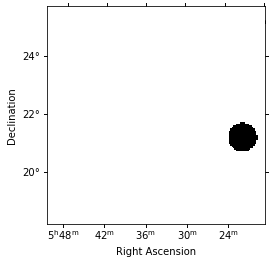

In [16]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot();

In [17]:
energy_axis = MapAxis.from_energy_bounds(
    0.05, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

In [18]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"],
    use_region_center=True
)
bkg_maker = ReflectedRegionsBackgroundMaker(min_distance_input="2 rad", 
                                            max_region_number=1,
                                            exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [19]:
#We can define the range we want to use for the fitting
e_reco_max=2
e_fit_min=0.01 * u.TeV
e_fit_max=100 * u.TeV

In [20]:
%%time
datasets = Datasets()

for obs_id, observation in zip(total_obs_list, observations_total):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    mask_fit = Map.from_geom(geom=dataset_on_off.counts.geom, data = dataset_on_off.counts.geom.get_coord()["energy"] < 10**e_reco_max * u.TeV)
    dataset_on_off.counts.geom.energy_mask(energy_min=e_fit_min, energy_max=e_fit_max)
    datasets.append(dataset_on_off)

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used wi

CPU times: user 8.44 s, sys: 955 ms, total: 9.39 s
Wall time: 11.5 s


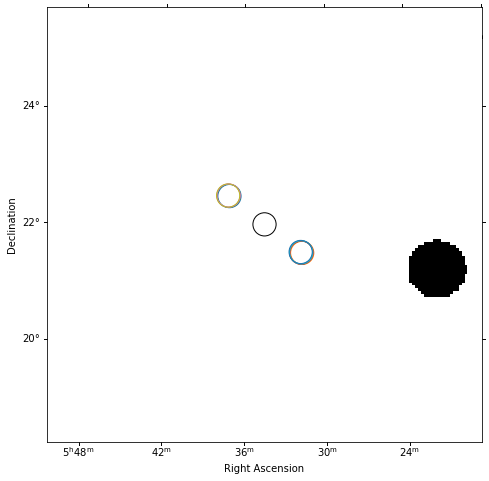

In [21]:
plt.figure(figsize=(8, 8))
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

In [22]:
#Print the information table

info_table = datasets.info_table(cumulative=True)
info_table

<Table length=11>
  name  counts background  excess ... acceptance acceptance_off  alpha 
                                  ...                                  
  str7  int64   float64   float32 ...  float64      float64     float64
------- ------ ---------- ------- ... ---------- -------------- -------
stacked    807      287.0   520.0 ...       26.0           26.0     1.0
stacked   1676      664.0  1012.0 ...       26.0           26.0     1.0
stacked   1971      821.0  1150.0 ...       26.0           26.0     1.0
stacked   2183      908.0  1275.0 ...       26.0           26.0     1.0
stacked   2612     1076.0  1536.0 ...       26.0           26.0     1.0
stacked   3273     1310.0  1963.0 ...       26.0           26.0     1.0
stacked   3908     1592.0  2316.0 ...       26.0           26.0     1.0
stacked   4138     1678.0  2460.0 ...       26.0           26.0     1.0
stacked   4608     1885.0  2723.0 ...       26.0           26.0     1.0
stacked   5130     2073.0  3057.0 ...       26.0           26.0     1.0
stacked   5423     2238.0  3185.0 ...       26.0           26.0     1.0

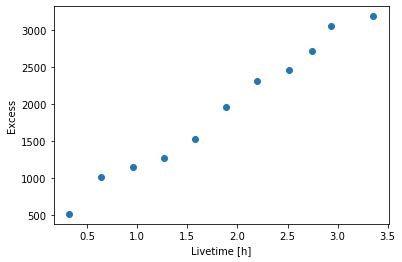

In [23]:
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");

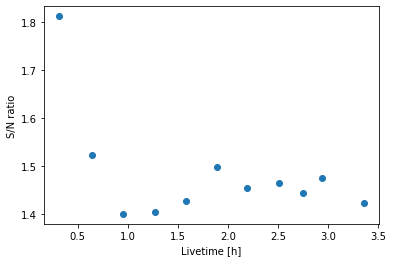

In [24]:
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"]/info_table["background"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("S/N ratio");

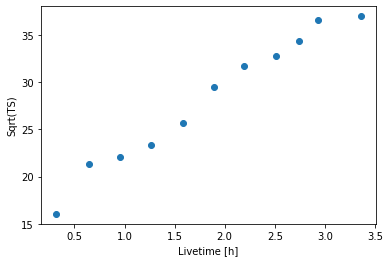

In [25]:
plt.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

In [26]:
#Create a folder to save the results
path = Path(basedir+"/spectrum_analysis")
path.mkdir(exist_ok=True)

In [27]:
for dataset in datasets:
    dataset.write(
        filename=path / f"obs_{dataset.name}.fits.gz", overwrite=True
    )

In [28]:
datasets = Datasets()

for obs_id in total_obs_list:
    filename = path / f"obs_{obs_id}.fits.gz"
    datasets.append(SpectrumDatasetOnOff.read(filename))

In [29]:
#Define here a the spectral model as a log parabola for the Crab. Fo any other source you can use a power law

log_parabola = LogParabolaSpectralModel(
    alpha=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", beta=0.1
)
model = SkyModel(spectral_model=log_parabola, name="crab")
datasets.models = [model]

In [59]:
spectral_model = PowerLawSpectralModel(
    index=3, amplitude=4e-13 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="rsophi")
datasets.models = [model]

In [30]:
#Fit the spectral model to the data

fit_joint = Fit()
result_joint = fit_joint.run(datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 183
	total stat : 715.23

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 183
	total stat : 715.23




In [31]:
pars= model.parameters.to_table()
pars

<Table length=4>
  type      name     value         unit      ...   min     max   frozen link
  str8      str9    float64       str14      ... float64 float64  bool  str1
-------- --------- ---------- -------------- ... ------- ------- ------ ----
spectral amplitude 1.4238e-11 cm-2 s-1 TeV-1 ...     nan     nan  False     
spectral reference 1.0000e+00            TeV ...     nan     nan   True     
spectral     alpha 2.5409e+00                ...     nan     nan  False     
spectral      beta 1.5200e-01                ...     nan     nan  False

In [32]:
model.parameters[2]

Parameter(name='alpha', value=2.540892980910544, factor=2.540892980910544, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x7f2917cb4820)

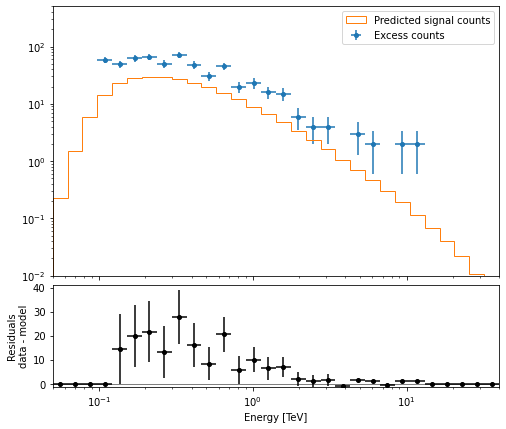

In [49]:
#Explore the residuals of the fitting
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.01, 500)

plt.show()

In [35]:
#Compute flux points
e_min, e_max = 0.05, 40
energy_edges = np.logspace(np.log10(e_min), np.log10(e_max), 30) * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")
#fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")
flux_points = fpe.run(datasets=datasets)
plot_kwargs = {
    "energy_bounds": [e_min, e_max] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

In [36]:
flux_points.to_table(sed_type="e2dnde", formatted=True)

<Table length=29>
 e_ref   e_min   e_max      e2dnde    ...   stat  is_ul  counts [11]  success
  TeV     TeV     TeV   TeV / (cm2 s) ...                                    
float64 float64 float64    float64    ... float64  bool    float64      bool 
------- ------- ------- ------------- ... ------- ----- ------------- -------
  0.056   0.050   0.062           nan ...   0.000  True    0.0 .. 0.0   False
  0.070   0.062   0.078           nan ...   0.000  True    0.0 .. 0.0   False
  0.087   0.078   0.098           nan ...   0.000  True    0.0 .. 0.0   False
  0.109   0.098   0.122           nan ...   0.000  True    0.0 .. 0.0   False
  0.136   0.122   0.152     2.838e-11 ...  26.128 False 130.0 .. 70.0    True
  0.170   0.152   0.190     2.233e-11 ...  40.695 False 114.0 .. 36.0    True
  0.213   0.190   0.238     2.446e-11 ...  65.263 False 112.0 .. 40.0    True
  0.266   0.238   0.297     1.875e-11 ...  52.571 False  84.0 .. 23.0    True
  0.332   0.297   0.371     2.422e-11 ...  87.535 False  99.0 .. 30.0    True
    ...     ...     ...           ... ...     ...   ...           ...     ...
  4.817   4.309   5.384     5.841e-12 ...  10.205 False    3.0 .. 2.0    True
  6.019   5.384   6.728     3.692e-12 ...  15.164 False    2.0 .. 0.0    True
  7.521   6.728   8.408           nan ...   6.978  True    0.0 .. 1.0   False
  9.398   8.408  10.506     3.579e-21 ...   4.159 False    2.0 .. 0.0    True
 11.744  10.506  13.128           nan ...   5.554  True    2.0 .. 0.0   False
 14.676  13.128  16.405     2.581e-19 ...   1.386 False    0.0 .. 0.0    True
 18.339  16.405  20.500     2.786e-20 ...   0.000 False    0.0 .. 0.0    True
 22.916  20.500  25.617     3.280e-29 ...   0.000 False    0.0 .. 0.0    True
 28.636  25.617  32.010    -2.124e-29 ...   0.000 False    0.0 .. 0.0    True
 35.783  32.010  40.000     1.115e-18 ...   0.000 False    0.0 .. 0.0    True

AttributeError: Quantity 'stat_scan' is not defined on current flux estimate.

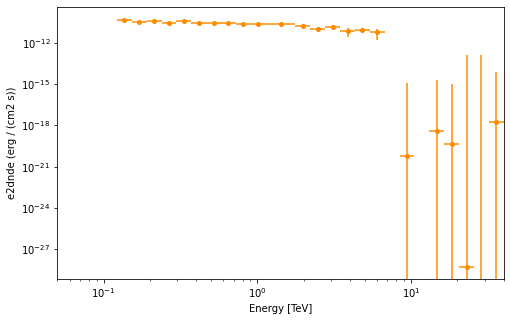

In [37]:
plt.figure(figsize=(8, 5))
ax = flux_points.plot(sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde");

In [38]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint
)

In [51]:
flux_points_dataset.plot_fit(ax_spectrum.xlim(0.01,20.))

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

AttributeError: 'Line2D' object has no property 'flux_unit'

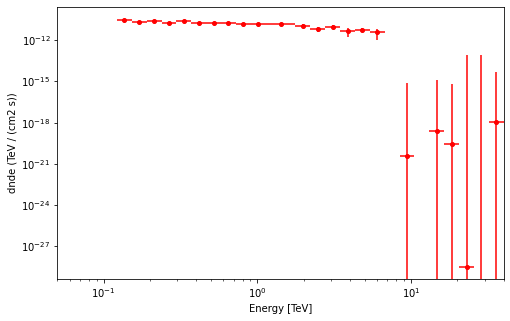

In [40]:
# plot joint model

plt.figure(figsize=(8, 5))

flux_points.to_table()["is_ul"] = flux_points.to_table()["ts"] < 3
ax = flux_points.plot(
    energy_power=2, color="red"
)

model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Fit result", ls="-"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="Crab reference"
)
plt.ylim([1e-11,2e-10])
#plt.xlim([5e-2, 1e1])
plt.legend()


In [62]:
model

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.LogParabolaSpectralModel object at 0x7f292337f750>)temporal_model=None)

In [50]:
#Other approach: Stacking the observatiosn first and then fitting the model

dataset_stacked = Datasets(datasets).stack_reduce()

dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 45
	total stat : 11.78



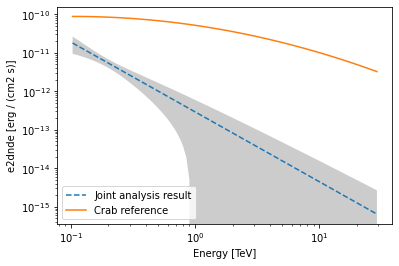

In [109]:
model_best_joint.parameters.to_table()

plot_kwargs = {
    "energy_bounds": [0.1, 30] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
}


# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="Crab reference"
)

plt.legend()

In [52]:
elow=hdul[1].data['ENERG_LO'][0]
ehigh=hdul[1].data['ENERG_HI'][0]
effarea=hdul[1].data['EFFAREA'][0][0]
bincenter=elow+(ehigh-elow)/2

NameError: name 'hdul' is not defined

In [ ]:
plt.plot(bincenter, effarea)
plt.xlabel("Energy[TeV]")
plt.ylabel("Effective Area [m2]")
plt.xscale('log')